In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [00:57<00:00, 31.5MB/s]
100% 1.98G/1.98G [00:57<00:00, 37.2MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip', 'r')
zip_ref.extractall('/content/fruit-vegetables')
zip_ref.close()

In [5]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.4 MB/s eta 0:00:00


In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2, InceptionResNetV2,MobileNetV2,Xception
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import numpy as np
from pathlib import Path
import tensorflow as tf
import pandas as pd

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/fruit-vegetables/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/fruit-vegetables/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/fruit-vegetables/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [8]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [9]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['cauliflower' 'spinach' 'beetroot' 'cabbage' 'orange' 'eggplant' 'mango'
 'cucumber' 'pineapple' 'peas' 'ginger' 'carrot' 'turnip' 'chilli pepper'
 'capsicum' 'apple' 'lettuce' 'pomegranate' 'jalepeno' 'grapes' 'potato'
 'pear' 'tomato' 'banana' 'onion' 'garlic' 'raddish' 'watermelon'
 'paprika' 'kiwi' 'corn' 'sweetcorn' 'bell pepper' 'soy beans' 'lemon'
 'sweetpotato']


In [10]:
# view the first five rows of the train dataframe
train_df.head(5)


,Filepath,Label
0,/content/fruit-vegetables/train/cauliflower/Im...,cauliflower
1,/content/fruit-vegetables/train/spinach/Image_...,spinach
2,/content/fruit-vegetables/train/beetroot/Image...,beetroot
3,/content/fruit-vegetables/train/cabbage/Image_...,cabbage
4,/content/fruit-vegetables/train/orange/Image_1...,orange


In [11]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index()
train_df['Label'].nunique()

36

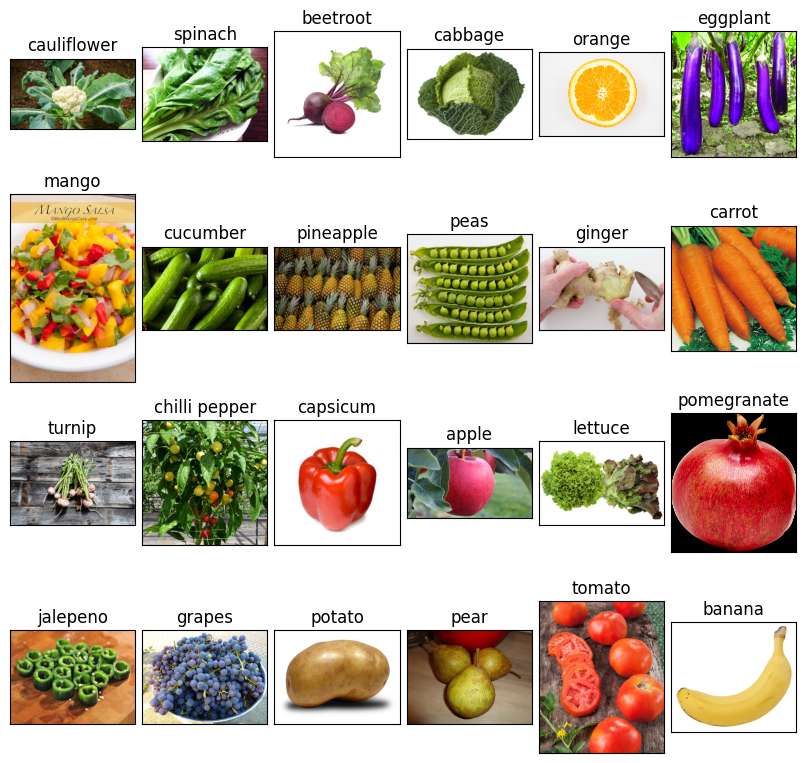

In [12]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.Filepath[i]))
    ax.set_title(unique_labels.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [27]:
from tensorflow.keras.applications import ResNet50

# Create image data generators with ResNet pre-processing
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Specify the target image size and other parameters
image_size = (224, 224)
batch_size = 32

# Create data generators for training, validation, and testing
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [29]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [30]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [36]:
# Add custom classification head on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Adjust the number of units if needed
x = Dense(len(train_images.class_indices), activation='softmax')(x)  # Output units match the number of classes

model = Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [37]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])



In [38]:
# Define the number of epochs, steps, and early stopping

early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
num_epochs = 5
steps_per_epoch = len(train_images)
validation_steps = len(val_images)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_images,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/5
87/87 [==============================] - 102s 1s/step - loss: 1.5258 - accuracy: 0.5968 - val_loss: 0.3705 - val_accuracy: 0.8922
Epoch 2/5
87/87 [==============================] - 87s 1s/step - loss: 0.4728 - accuracy: 0.8615 - val_loss: 0.2581 - val_accuracy: 0.9222
Epoch 3/5
87/87 [==============================] - 87s 999ms/step - loss: 0.2456 - accuracy: 0.9277 - val_loss: 0.2063 - val_accuracy: 0.9341
Epoch 4/5
87/87 [==============================] - 96s 1s/step - loss: 0.1739 - accuracy: 0.9511 - val_loss: 0.1347 - val_accuracy: 0.9641
Epoch 5/5
87/87 [==============================] - 94s 1s/step - loss: 0.1054 - accuracy: 0.9730 - val_loss: 0.1182 - val_accuracy: 0.9641


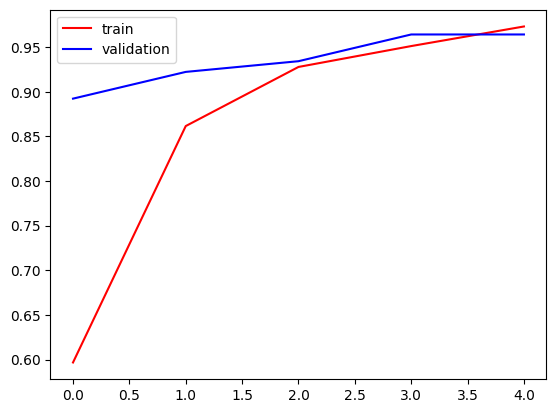

In [39]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

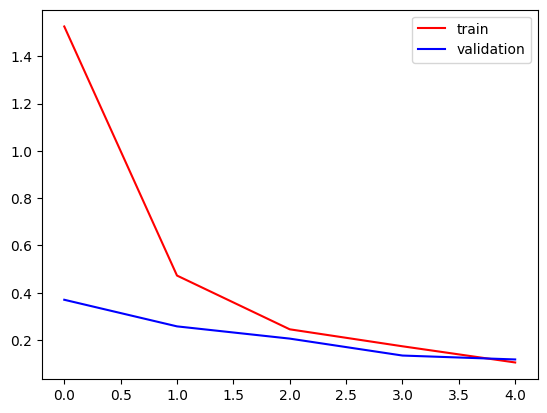

In [40]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [51]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

11/11 [==============================] - 15s 1s/step


In [52]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 96.41%


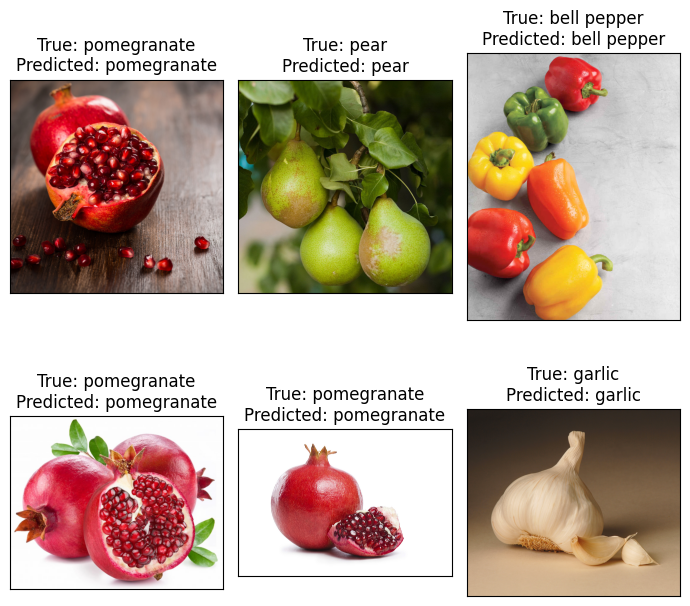

In [53]:
import matplotlib.pyplot as plt

# Select a few random test samples for display
sample_indices = np.random.choice(len(test_df), size=9, replace=False)
sample_images = [plt.imread(test_df.Filepath.iloc[i]) for i in sample_indices]
sample_labels = [f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}" for i in sample_indices]

# Display the sample images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, img, label in zip(axes.flat, sample_images, sample_labels):
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()


